# Proyek Klasifikasi Gambar: Vehicle Detection Image Set
- **Nama:** Ridho Awwaludin
- **Email:** ridhoawwaludin@gmail.com
- **ID Dicoding:** ridho_awwaludin_th0e

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from google.colab import files

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
# Install tensorflowjs
!pip install tensorflowjs

## Data Preparation

### Data Loading

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ridhoawwaludin","key":"4db4aa3c069a944c4ed2d6dc3800c1f4"}'}

In [6]:
!rm -rf vehicle-detection-image-set

In [7]:
# Download kaggle dataset and unzip the file
# 1. Buat direktori .kaggle di home directory
!mkdir -p ~/.kaggle

# 2. Salin file kaggle.json ke direktori tersebut
!cp kaggle.json ~/.kaggle/

# 3. Setel izin (permission) agar file hanya bisa dibaca oleh Anda
!chmod 600 ~/.kaggle/kaggle.json

# 4. Sekarang jalankan perintah download Anda
!kaggle datasets download -d brsdincer/vehicle-detection-image-set

# 5. Unzip file (sekarang file .zip seharusnya sudah ada)
!unzip vehicle-detection-image-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

In [8]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

In [9]:
dataset_folder = 'data'
print_images_resolution(dataset_folder)

vehicles: 8792
- (64, 64)
---------------
non-vehicles: 8968
- (64, 64)
---------------

Total: 17760


### Data Preprocessing

#### Split Dataset

In [10]:
!rm -rf data/test data/train data/val data/splitted

In [11]:
!pip install split-folders

In [12]:
import splitfolders
# Membagi Dataset Menjadi Train, Validation, dan Test Set

output_folder = "splitted"

print("Sedang memproses pembagian data...")


splitfolders.ratio(
    dataset_folder,
    output=output_folder,
    seed=1337,
    ratio=(.8, .1, .1),
    group_prefix=None,
    move=False
)

print(f"Selesai! Data telah terbagi di folder '{output_folder}'.")

Sedang memproses pembagian data...


Copying files: 17760 files [00:02, 7261.88 files/s]

Selesai! Data telah terbagi di folder 'splitted'.


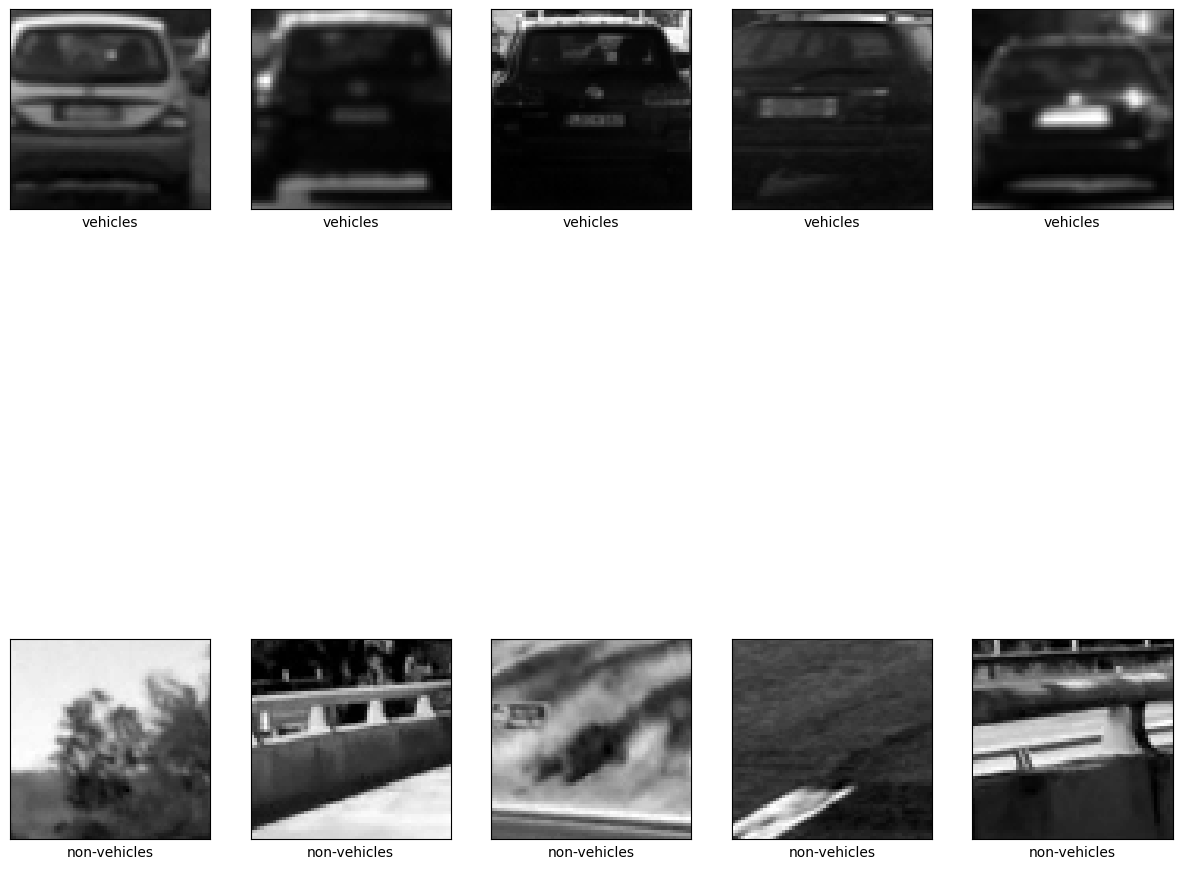

In [13]:
# Dataset Checking

vehicle_image = {}

# Tentukan path sumber train
path = "data"
path_sub = os.path.join(path)
for i in os.listdir(path_sub):
    vehicle_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "data"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(vehicle_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(vehicle_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

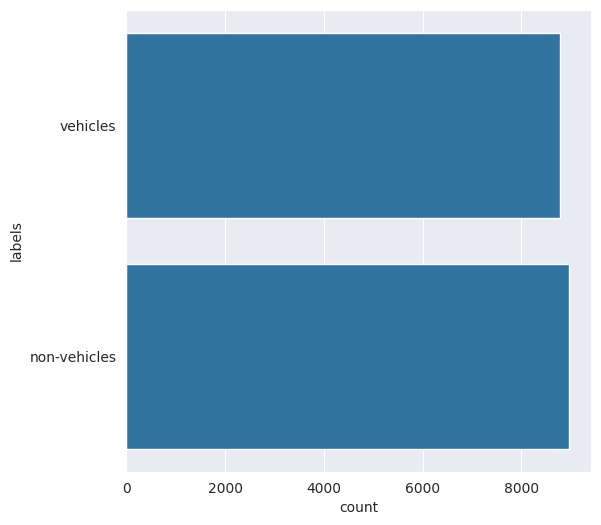

In [14]:
# Define source path
data_path = "data"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(data_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [15]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'data'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
non-vehicles,8968
vehicles,8792


In [16]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [17]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [18]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 14208
test size 3552


In [19]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels      
test   non-vehicles    1788
       vehicles        1764
train  non-vehicles    7180
       vehicles        7028
dtype: int64 


                                 path        labels    set
7981           data/vehicles/4794.png      vehicles  train
2125  data/non-vehicles/extra2564.png  non-vehicles  train
6628           data/vehicles/2452.png      vehicles  train
8776  data/non-vehicles/image2268.png  non-vehicles  train
5726           data/vehicles/1537.png      vehicles  train


In [20]:
# Define training and test directories
TRAIN_DIR = "splitted/train/"
TEST_DIR = "splitted/test/"

train_vehicles = os.path.join(TRAIN_DIR + '/vehicles')
train_non_vehicles = os.path.join(TRAIN_DIR + '/non-vehicles')
test_vehicles = os.path.join(TEST_DIR + '/vehicles')
test_non_vehicles = os.path.join(TEST_DIR + '/non-vehicles')

print("Total number of vehicle images in training set: ",len(os.listdir(train_vehicles)))
print("Total number of non vehicles images in training set: ",len(os.listdir(train_non_vehicles)))
print("Total number of vehicle images in test set: ",len(os.listdir(test_vehicles)))
print("Total number of non vehicles images in test set: ",len(os.listdir(test_non_vehicles)))

Total number of vehicle images in training set:  7033
Total number of non vehicles images in training set:  7174
Total number of vehicle images in test set:  880
Total number of non vehicles images in test set:  898


In [21]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 11367 images belonging to 2 classes.
Found 2840 images belonging to 2 classes.
Found 1778 images belonging to 2 classes.


## Modelling

In [22]:
####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [23]:
count_normal, count_pneumonia = len(os.listdir(train_vehicles)), len(os.listdir(train_non_vehicles))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


356/356 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.7896 - loss: 1.0500 - val_accuracy: 0.5049 - val_loss: 11.1054
Epoch 2/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9424 - loss: 0.2262 - val_accuracy: 0.9408 - val_loss: 0.1673
Epoch 3/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9677 - loss: 0.1183 - val_accuracy: 0.9863 - val_loss: 0.0441
Epoch 4/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9787 - loss: 0.0926 - val_accuracy: 0.9908 - val_loss: 0.0334
Epoch 5/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9827 - loss: 0.0768 - val_accuracy: 0.9884 - val_loss: 0.0342
Epoch 6/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9870 - loss: 0.0403 - val_accuracy: 0.8254 - val_loss: 3.2126
Epoch 7/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9838 - loss: 0.0574 - val_accuracy: 0.9842 - val_loss: 0.0638
Epoch 8/30
356/356 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9903 - loss: 0.0403 - val_accura

## Evaluasi dan Visualisasi

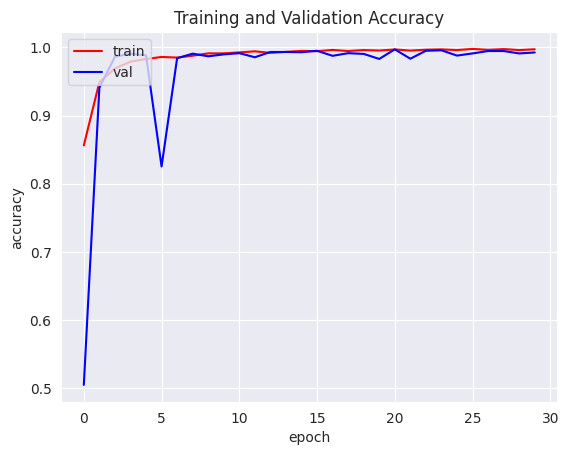

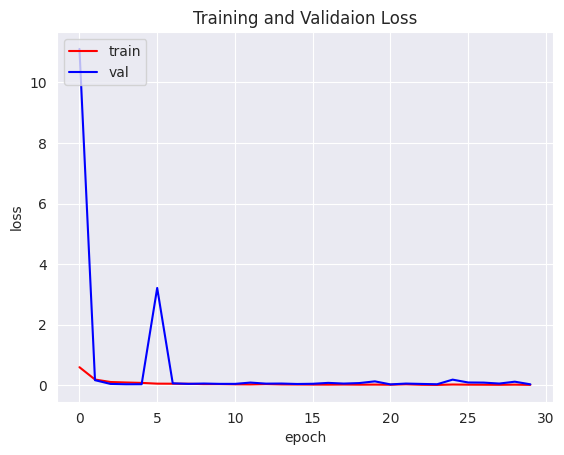

In [24]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

     Vehicle     0.9423    1.0000    0.9703       898
 Non Vehicle     1.0000    0.9375    0.9677       880

    accuracy                         0.9691      1778
   macro avg     0.9711    0.9688    0.9690      1778
weighted avg     0.9709    0.9691    0.9690      1778



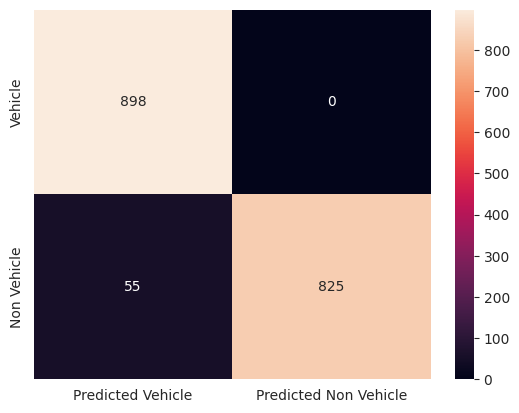

In [25]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Vehicle", "Non Vehicle"],
columns=["Predicted Vehicle", "Predicted Non Vehicle"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =["Vehicle", "Non Vehicle"], digits=4))

## Konversi Model

In [26]:
export_dir = 'model/'

## tfjs

In [27]:
model_1.save(export_dir + "h5/model.h5")


!tensorflowjs_converter --input_format=keras model/h5/model.h5 model/tfjs/tfjs_model

2025-12-01 01:57:56.304893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764554276.325409    4773 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764554276.331871    4773 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764554276.347251    4773 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764554276.347276    4773 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764554276.347280    4773 computation_placer.cc:177] computation placer alr

## TFLite

In [28]:
# The line below caused a TypeError and is not strictly necessary for TFLite conversion from a Keras model.
# tf.saved_model.save(model_1, 'model/saved_model/')

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model/tflite/model.tflite')
tflite_model_file.parent.mkdir(parents=True, exist_ok=True) # Create the directory if it doesn't exist
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmpdc71tqbr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133410598924176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598925328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598924368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598926096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598920336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598923984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598924752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598928208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598927440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598927248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13341059892705

5616964

## SavedModel

In [29]:
save_path = os.path.join("model/saved_model")
# Create the directory if it doesn't exist
pathlib.Path(save_path).mkdir(parents=True, exist_ok=True)
# Export the model to TensorFlow SavedModel format (.pb file within the directory)
model_1.export(save_path)

Saved artifact at 'model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133410598924176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598925328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598924368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598926096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598920336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598923984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598924752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598928208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598927440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133410598927248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1334105989270

## Inference (Optional)

# Model Library Requirements

In [30]:
!pip freeze > requirements.txt

In [32]:
!zip -r submission.zip model requirements.txt

  adding: model/ (stored 0%)
  adding: model/tflite/ (stored 0%)
  adding: model/tflite/model.tflite (deflated 8%)
  adding: model/saved_model/ (stored 0%)
  adding: model/saved_model/saved_model.pb (deflated 88%)
  adding: model/saved_model/variables/ (stored 0%)
  adding: model/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model/saved_model/variables/variables.index (deflated 71%)
  adding: model/saved_model/fingerprint.pb (stored 0%)
  adding: model/saved_model/assets/ (stored 0%)
  adding: model/h5/ (stored 0%)
  adding: model/h5/model.h5 (deflated 8%)
  adding: model/tfjs/ (stored 0%)
  adding: model/tfjs/tfjs_model/ (stored 0%)
  adding: model/tfjs/tfjs_model/model.json (deflated 89%)
  adding: model/tfjs/tfjs_model/group1-shard2of2.bin (deflated 7%)
  adding: model/tfjs/tfjs_model/group1-shard1of2.bin (deflated 7%)
  adding: requirements.txt (deflated 58%)
